# LAPD Crime Incidents EDA

Monthly LAPD incident data aggregated by ZIP Code Tabulation Area (ZCTA) from **April 2020 through June 2022**. Each record contains violent and non-violent incident counts plus lagged violent counts and ACS population estimates. The purpose of this notebook is to surface distribution patterns, temporal trends, and key drivers that inform violent-crime forecasting and resource allocation.

**Notebook guide**
- Data preparation and quality checks
- Distribution analysis and hotspot inspection
- Time-based trends and seasonality
- Correlations, relationships, and feature importance
- Per-capita, spatial, and crime-mix perspectives
- Key takeaways and recommended next steps

In [ ]:
from pathlib import Path
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd
import contextily as cx
from pyproj import Transformer

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", None)
Path("plots").mkdir(parents=True, exist_ok=True)

## Data preparation

In [191]:
DATA_PATH = Path("data/processed/train.csv")
incidents = pd.read_csv(DATA_PATH)

if "Unnamed: 0" in incidents.columns:
    incidents = incidents.drop(columns=["Unnamed: 0"])

incidents.columns = (
    incidents.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^0-9a-z]+", "_", regex=True)
)

incidents = incidents.rename(columns={"zcta": "zip"})
zip_series = incidents["zip"].astype(str)
extracted_zip = zip_series.str.extract(r"(\d{5})", expand=False)
incidents["zip"] = extracted_zip.fillna(zip_series).str.zfill(5)

pop_candidates = [
    "total_population",
    "population",
    "total_pop",
    "pop_total",
    "acs_total_population",
]
found_pop = next((c for c in pop_candidates if c in incidents.columns), None)
if found_pop is None:
    for c in incidents.columns:
        if "population" in c:
            found_pop = c
            break
if found_pop and found_pop != "total_population":
    incidents = incidents.rename(columns={found_pop: "total_population"})

incidents["incident_month_timestamp"] = pd.to_datetime(incidents["incident_month_timestamp"])
incidents = incidents.sort_values(["zip", "incident_month_timestamp"]).reset_index(drop=True)
incidents["year"] = incidents["incident_month_timestamp"].dt.year
incidents["month"] = incidents["incident_month_timestamp"].dt.month

# Compute total crimes
if "crime_non_violent" in incidents.columns and "crime_violent" in incidents.columns:
    incidents["crime_total"] = incidents["crime_non_violent"].fillna(0) + incidents["crime_violent"].fillna(0)

# Define numeric features
numeric_features_all = [
    "crime_non_violent",
    "crime_violent",
    "violent_lag_1",
    "violent_lag_2",
    "violent_lag_3",
    "total_population",
]
numeric_features = [c for c in numeric_features_all if c in incidents.columns]

incidents.head()

,zip,incident_month_timestamp,crime_non_violent,crime_violent,violent_lag_1,violent_lag_2,violent_lag_3,season,month_sin,month_cos,total_population,median_household_income,gini_index,unemployment_rate,poverty_rate,year,month,crime_total
0,90001,2020-04-01,16.0,25.0,16.0,12.0,38.0,spring,8.660254e-01,-0.500000,56403,60751.0,0.416,0.096901,0.205254,2020,4,41.0
1,90001,2020-05-01,31.0,22.0,25.0,16.0,12.0,spring,5.000000e-01,-0.866025,56403,60751.0,0.416,0.096901,0.205254,2020,5,53.0
2,90001,2020-06-01,29.0,36.0,22.0,25.0,16.0,summer,1.224647e-16,-1.000000,56403,60751.0,0.416,0.096901,0.205254,2020,6,65.0
3,90001,2020-07-01,37.0,27.0,36.0,22.0,25.0,summer,-5.000000e-01,-0.866025,56403,60751.0,0.416,0.096901,0.205254,2020,7,64.0
4,90001,2020-08-01,24.0,29.0,27.0,36.0,22.0,summer,-8.660254e-01,-0.500000,56403,60751.0,0.416,0.096901,0.205254,2020,8,53.0


The dataset contains **4,023 month–ZCTA observations** covering 149 unique ZIP codes. We track the period from April 2020 through June 2022 for train EDA. 

In [ ]:
row_count = incidents.shape[0]
zip_count = incidents["zip"].nunique()
month_min = incidents["incident_month_timestamp"].min()
month_max = incidents["incident_month_timestamp"].max()

print(f"Rows: {row_count:,} across {zip_count} ZIP codes")
print(f"Observation window: {month_min:%Y-%m} to {month_max:%Y-%m}")
print("Missing values by column:")
print(incidents.isna().sum())

summary_stats = (
    incidents[numeric_features]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T
    .rename(columns={"25%": "q1", "50%": "median", "75%": "q3"})
)
summary_view = summary_stats.loc[:, ["min", "q1", "median", "q3", "max", "mean", "std"]]
display(summary_view)

Rows: 4,023 across 149 ZIP codes
Observation window: 2020-04 to 2022-06
Missing values by column:
zip                           0
incident_month_timestamp      0
crime_non_violent             0
crime_violent                 0
violent_lag_1                 0
violent_lag_2                 0
violent_lag_3                 0
season                        0
month_sin                     0
month_cos                     0
total_population              0
median_household_income     243
gini_index                  216
unemployment_rate           108
poverty_rate                108
year                          0
month                         0
crime_total                   0
dtype: int64


,min,q1,median,q3,max,mean,std
crime_non_violent,0.0,6.0,73.0,120.0,349.0,75.908277,67.576594
crime_violent,0.0,2.0,27.0,66.0,296.0,41.395227,47.165087
violent_lag_1,0.0,2.0,27.0,65.0,296.0,41.108128,46.765600
violent_lag_2,0.0,2.0,26.0,65.0,296.0,40.900323,46.600418
violent_lag_3,0.0,2.0,26.0,65.0,296.0,40.910266,46.552187
total_population,0.0,21436.0,31843.0,46153.0,102784.0,34438.181208,20624.977897


Median monthly violent incidents per ZCTA is 26 (IQR ≈ 2–66) with a maximum near 300, signalling a heavy right tail of hotspot neighbourhoods. Non-violent counts average ~75 and are similarly skewed. Population estimates range from under 1k to more than 100k, foreshadowing the need for rate-based comparisons.

### Data quality checks

In [193]:
quality_summary = {}

zero_pop = incidents[incidents["total_population"] == 0]["zip"].unique()
quality_summary["zero_population_zips"] = list(zero_pop)
quality_summary["zero_population_rows"] = int((incidents["total_population"] == 0).sum())

incident_mismatch = np.isclose(
    incidents["crime_total"],
    incidents["crime_non_violent"] + incidents["crime_violent"],
    atol=1e-6,
).all()
quality_summary["crime_total_valid"] = bool(incident_mismatch)

duplicates = incidents.duplicated(subset=["zip", "incident_month_timestamp"])
quality_summary["duplicate_zip_month_rows"] = int(duplicates.sum())

# Calculate the total crime incidents for each zip code
crime_total_90052 = incidents[incidents['zip'] == '90052']['crime_total'].sum()
crime_total_90079 = incidents[incidents['zip'] == '90079']['crime_total'].sum()

# Print the totals
print("Total crimes in zip code 90052:", crime_total_90052)
print("Total crimes in zip code 90079:", crime_total_90079)

quality_df = pd.Series(quality_summary, name="value").to_frame()
quality_df

Total crimes in zip code 90052: 27.0
Total crimes in zip code 90079: 29.0


,value
zero_population_zips,"[90052, 90079, 90095, 91371]"
zero_population_rows,108
crime_total_valid,True
duplicate_zip_month_rows,0


In [242]:
# Not dropping 0 population areas yet since they have crimes reported at them. 
# incidents["total_population"] = pd.to_numeric(incidents["total_population"], errors="coerce")

# zero_pop_mask = incidents["total_population"] == 0
# n_zero = int(zero_pop_mask.sum())
# zero_zips = incidents.loc[zero_pop_mask, "zip"].dropna().unique().tolist()

# print(f"Dropping {n_zero} rows across {len(zero_zips)} ZIP(s) with total_population == 0")
# if zero_zips:
#     print("ZIPs removed:", sorted(zero_zips))

# incidents = incidents.loc[~zero_pop_mask].reset_index(drop=True)

# incidents = incidents[incidents["total_population"].notna()].reset_index(drop=True)
# incidents["population_for_rates"] = incidents["total_population"].replace({0: np.nan})
# print("total_population dtype:", incidents["total_population"].dtype)
# remaining_zero = int((incidents["total_population"] == 0).sum())
# print(f"Rows with total_population == 0 after drop: {remaining_zero}")
# near_zero_mask = incidents["total_population"].between(0, 50, inclusive="both")
# print(f"Rows with total_population between 0 and 50: {int(near_zero_mask.sum())}")
# print("Five smallest populations after drop:")
# print(incidents["total_population"].nsmallest(5).to_list())
# assert remaining_zero == 0, "There are still rows with zero population present."
# mask_38 = np.isclose(incidents["total_population"], 38)
# rows_38 = int(mask_38.sum())
# zips_38 = incidents.loc[mask_38, "zip"].dropna().unique().tolist()
# print(f"Rows with total_population == 38: {rows_38}")
# print(f"ZIPs with total_population == 38 ({len(zips_38)}):", sorted(zips_38))
# if rows_38:
#     display(incidents.loc[mask_38, ["zip", "incident_month_timestamp", "total_population"]].head(10))

**5 ZIP codes** report a population of zero:
- PO boxes: `90052`, `90079`,
- UCLA: `90095`
- LA Pierce College: `91371`
- Universal Studios: `91608` (population 38)

They will be excluded automatically whenever per-capita metrics are computed (population is replaced with `NaN`). No duplicate month–ZIP combinations were detected, and the derived total incident count reconciles with the individual violent/non-violent series.

## Distribution of key features

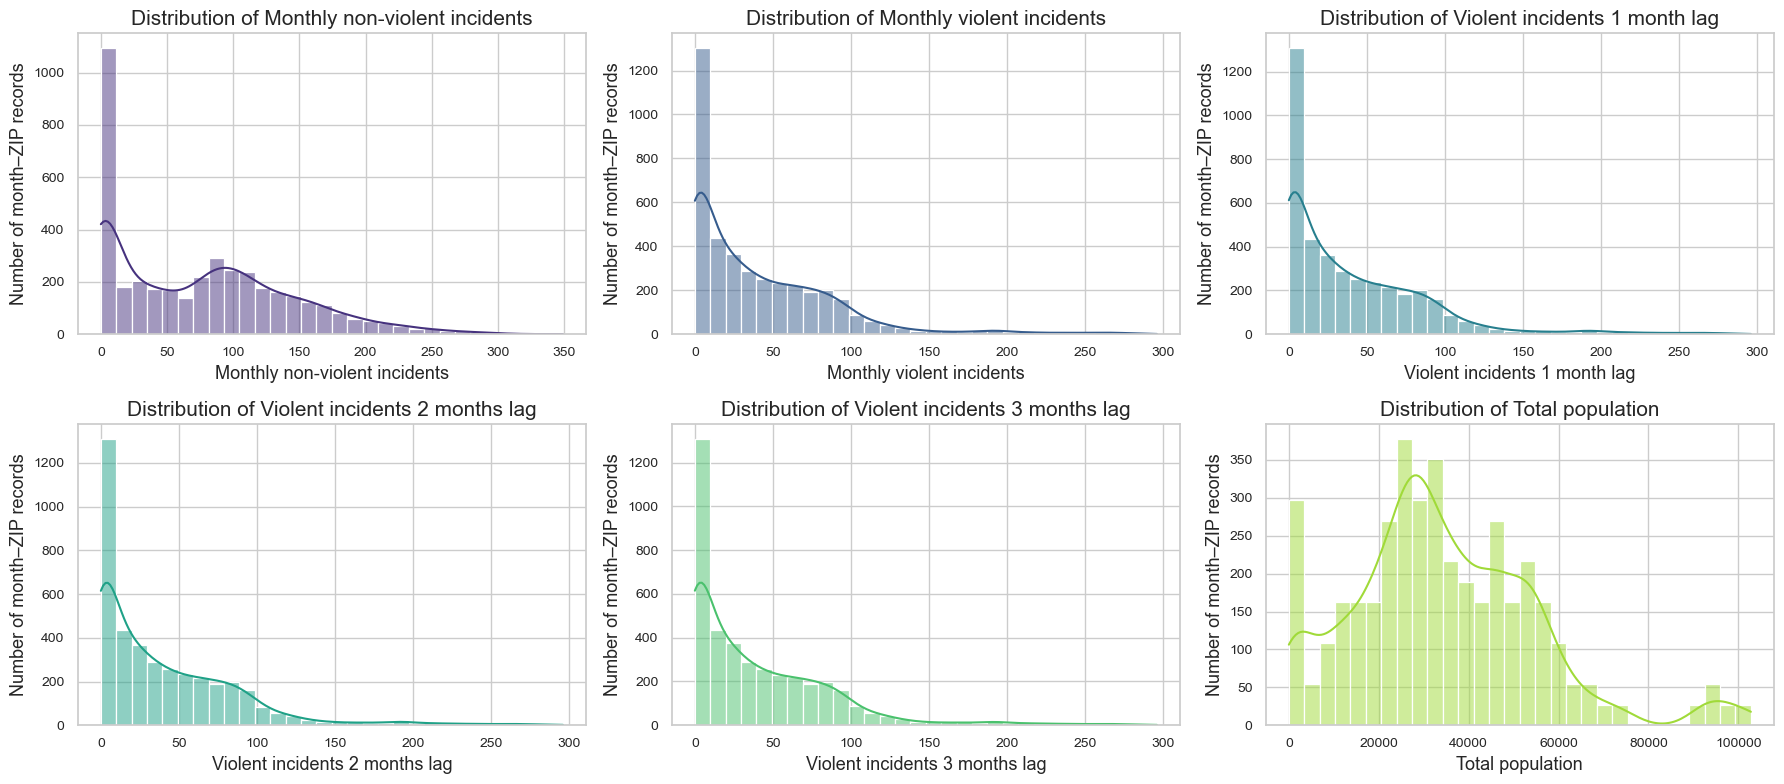

In [ ]:
feature_titles = {
    "crime_non_violent": "Monthly non-violent incidents",
    "crime_violent": "Monthly violent incidents",
    "violent_lag_1": "Violent incidents 1 month lag",
    "violent_lag_2": "Violent incidents 2 months lag",
    "violent_lag_3": "Violent incidents 3 months lag",
    "total_population": "Total population",
}
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()
colors = sns.color_palette("viridis", len(numeric_features))
title_fs = 15  
label_fs = 13
axes_used = 0
for idx, feature in enumerate(numeric_features):
    sns.histplot(
        data=incidents,
        x=feature,
        bins=30,
        kde=True,
        ax=axes[idx],
        color=colors[idx],
    )
    axes[idx].set_title(f"Distribution of {feature_titles.get(feature, feature)}", fontsize=title_fs)
    axes[idx].set_xlabel(feature_titles.get(feature, feature), fontsize=label_fs)
    axes[idx].set_ylabel("Number of month–ZIP records", fontsize=label_fs)
    axes[idx].tick_params(axis='both', labelsize=10)
    axes_used += 1
for ax in axes[len(numeric_features):]:
    ax.remove()
plt.tight_layout()
plt.show()

All distributions are right-skewed: most communities record relatively few incidents, while a small subset experiences repeated high volumes. The lag features mirror current violent counts, signalling strong temporal persistence. Population has its own heavy tail because a handful of ZIP codes represent dense neighbourhoods.

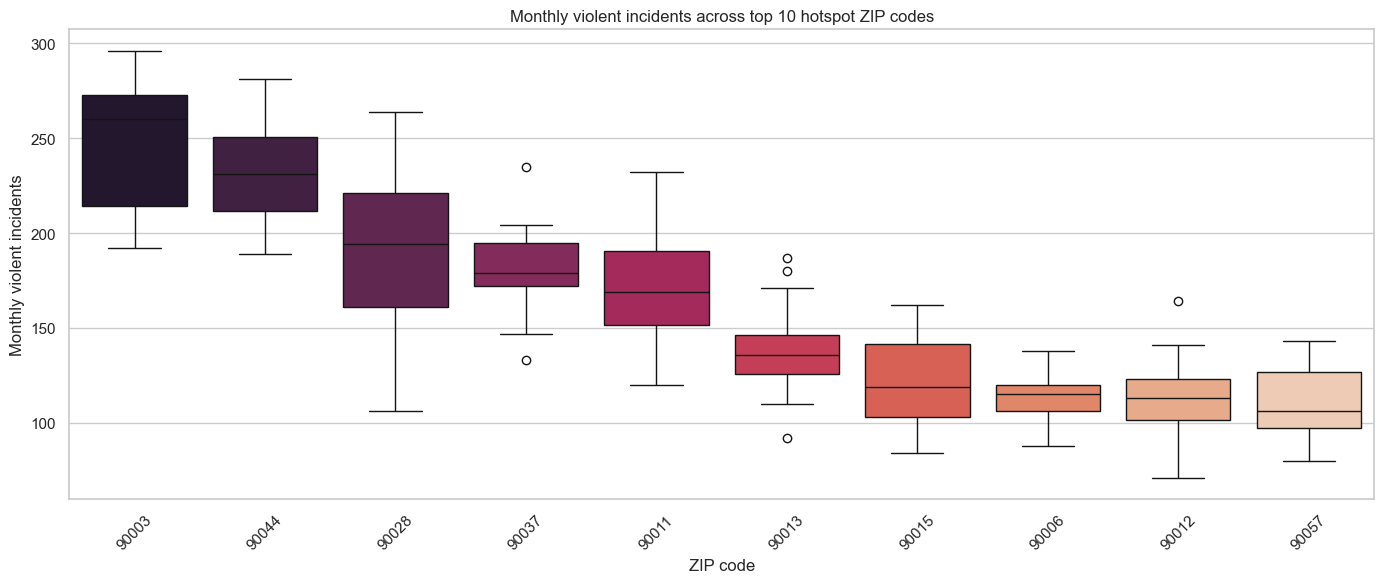

In [ ]:
top_hotspots = (
    incidents.groupby("zip")["crime_violent"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=incidents[incidents["zip"].isin(top_hotspots)],
    x="zip",
    y="crime_violent",
    order=top_hotspots,
    palette="rocket",
)
plt.title("Monthly violent incidents across top 10 hotspot ZIP codes")
plt.xlabel("ZIP code")
plt.ylabel("Monthly violent incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hotspot ZIP codes such as 90003, 90044, and 90028 consistently top the rankings. Their monthly interquartile ranges span roughly 40–90 incidents, with frequent spikes exceeding 200—highlighting persistent load on local resources.

## Time-based patterns

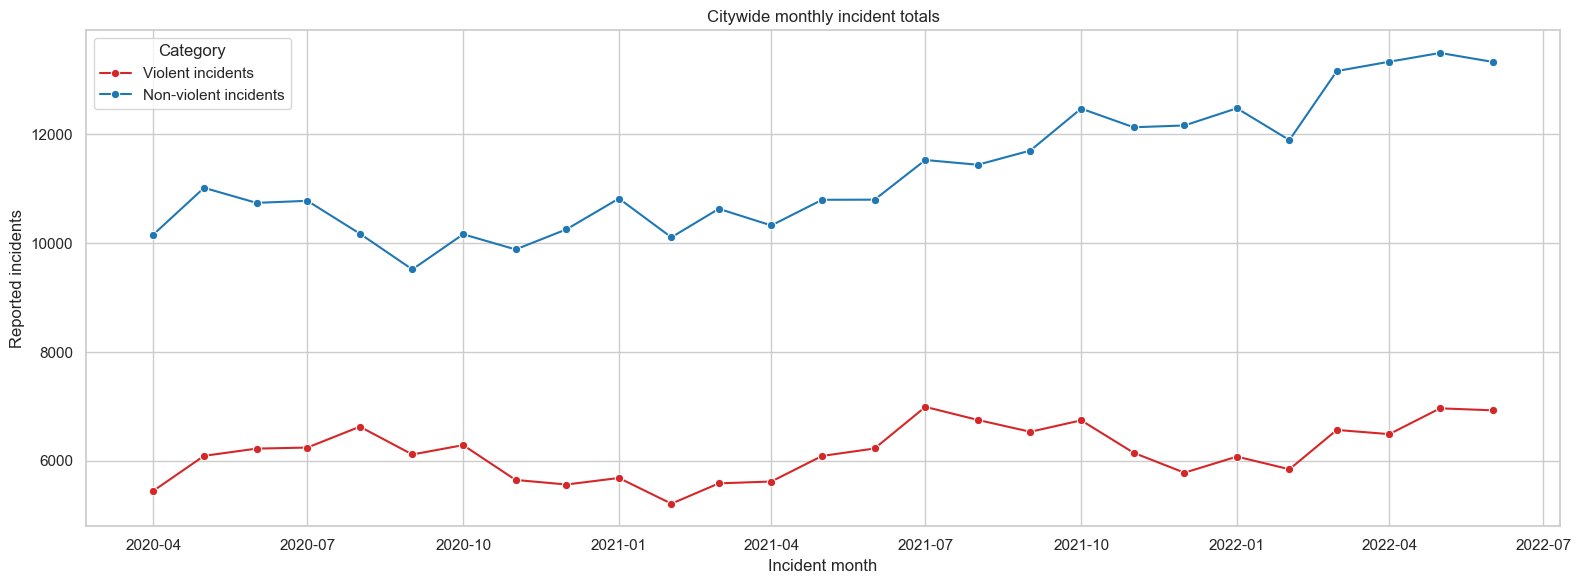

In [ ]:
citywide_monthly = (
    incidents.groupby("incident_month_timestamp")[
        ["crime_violent", "crime_non_violent"]
    ]
    .sum()
    .reset_index()
)

plt.figure(figsize=(16, 6))
for column, label, color in [
    ("crime_violent", "Violent incidents", "#d62728"),
    ("crime_non_violent", "Non-violent incidents", "#1f77b4"),
]:
    sns.lineplot(
        data=citywide_monthly,
        x="incident_month_timestamp",
        y=column,
        label=label,
        marker="o",
        color=color,
    )
plt.title("Citywide monthly incident totals")
plt.xlabel("Incident month")
plt.ylabel("Reported incidents")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

Citywide totals dipped at the start of the series (pandemic lockdown) but climbed steadily through 2022. Violent incidents increased roughly 25%, while non-violent incidents nearly doubled, suggesting broad-based growth in reported activity.

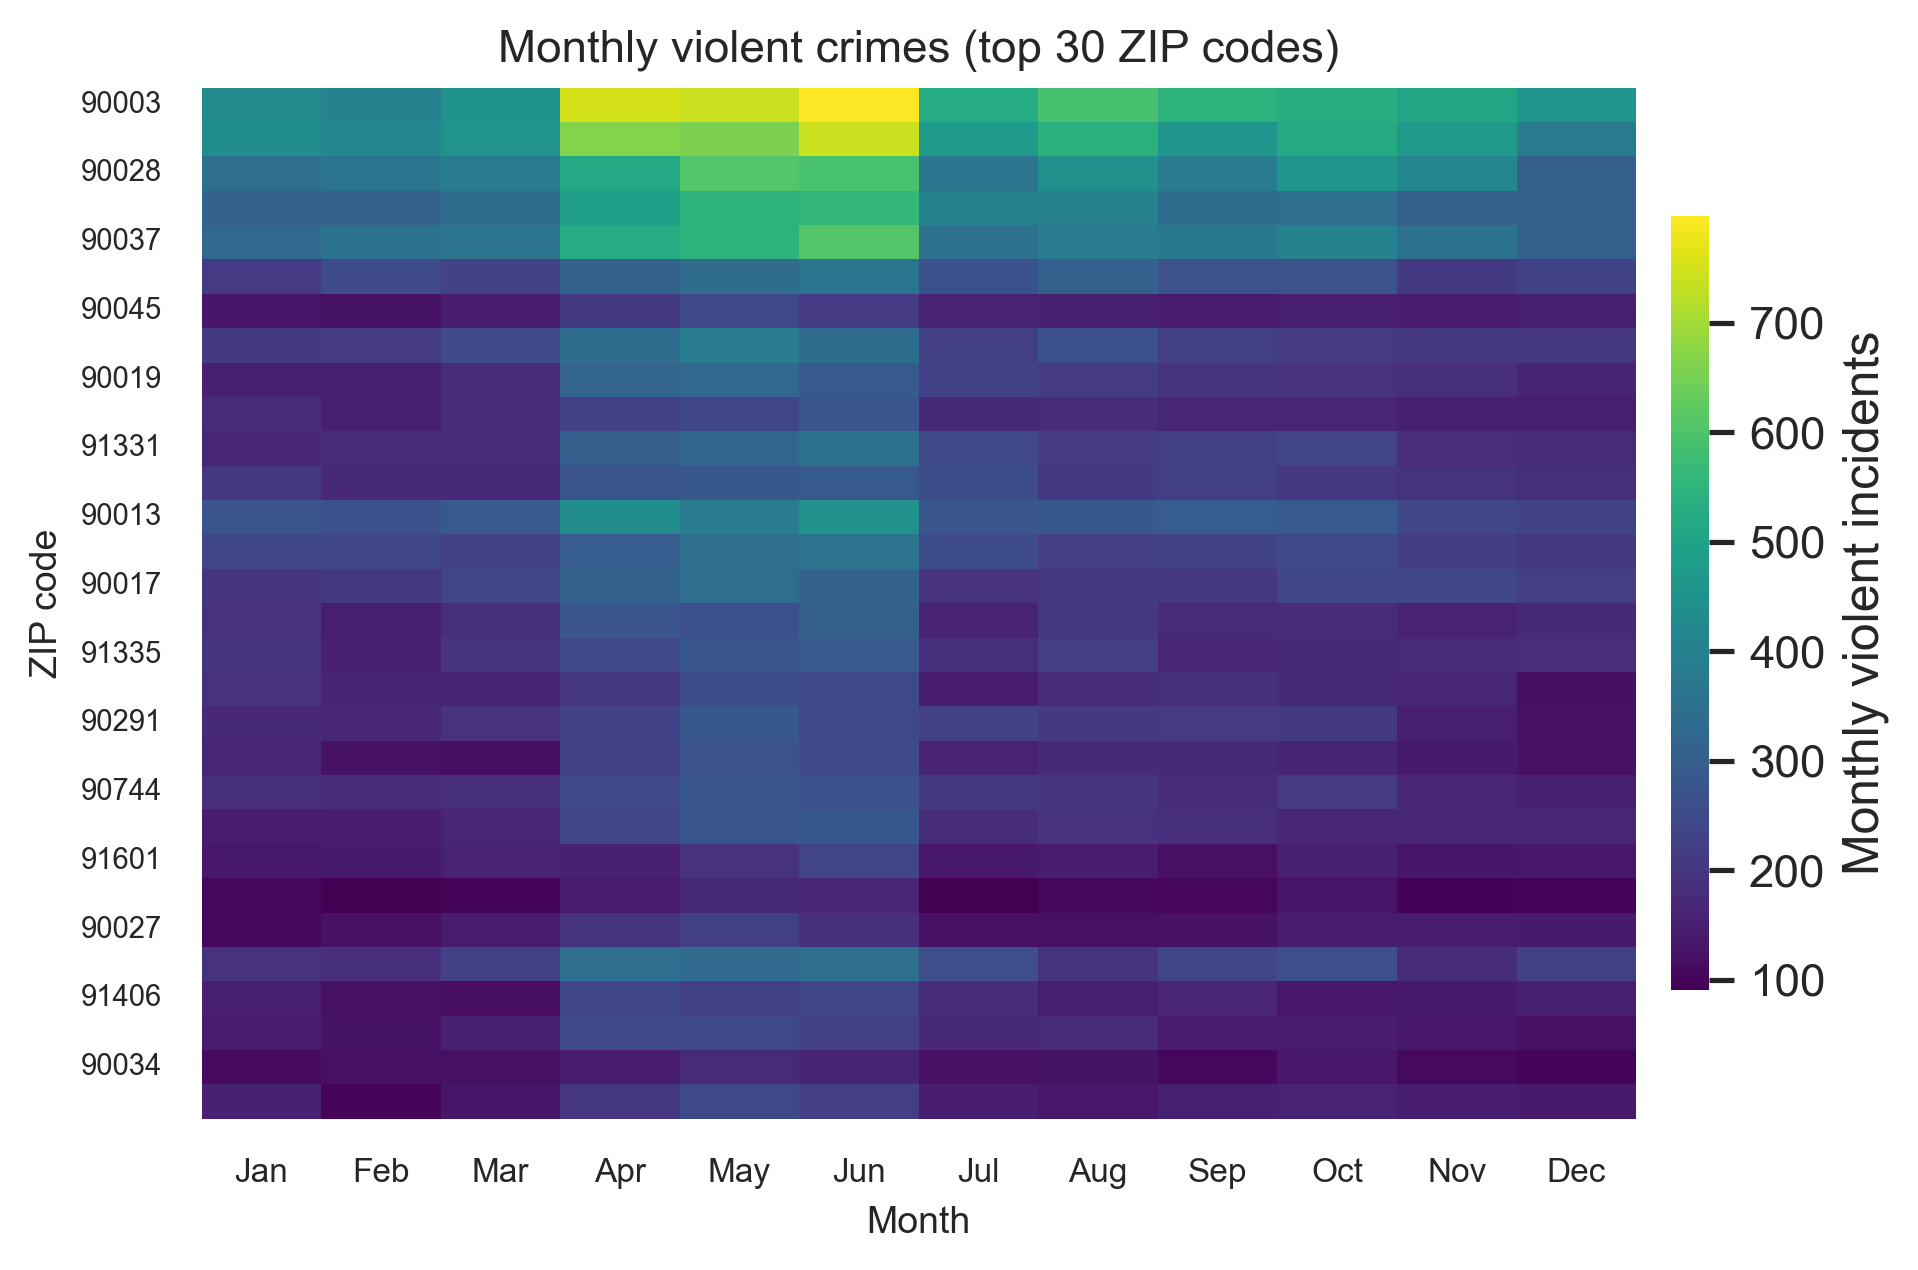

Saved compact Word-optimized heatmap to: /Users/matildaorona/github/207_ML/DS207_Final_Project/plots/heatmap_monthly_violent_top30_word_compact.png


In [225]:
fig_w_in = 6.5
fig_h_in = 4.2
fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=300)
sns.heatmap(
    heat_v, cmap="viridis", ax=ax,
    cbar_kws={"shrink": 0.75, "pad": 0.02, "label": "Monthly violent incidents"}
)
ax.set_title("Monthly violent crimes (top 30 ZIP codes)", fontsize=11, pad=6)
ax.set_xlabel("Month", fontsize=9)
ax.set_ylabel("ZIP code", fontsize=9)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=7)
ax.set_xticks(np.arange(12) + 0.5)
ax.set_xticklabels(month_names)

plt.tight_layout(pad=0.5)
export_path = Path("plots/heatmap_monthly_violent_top30_word_compact.png")
plt.savefig(export_path, dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()
print(f"Saved compact Word-optimized heatmap to: {export_path.resolve()}")

## Seasonality Patterns

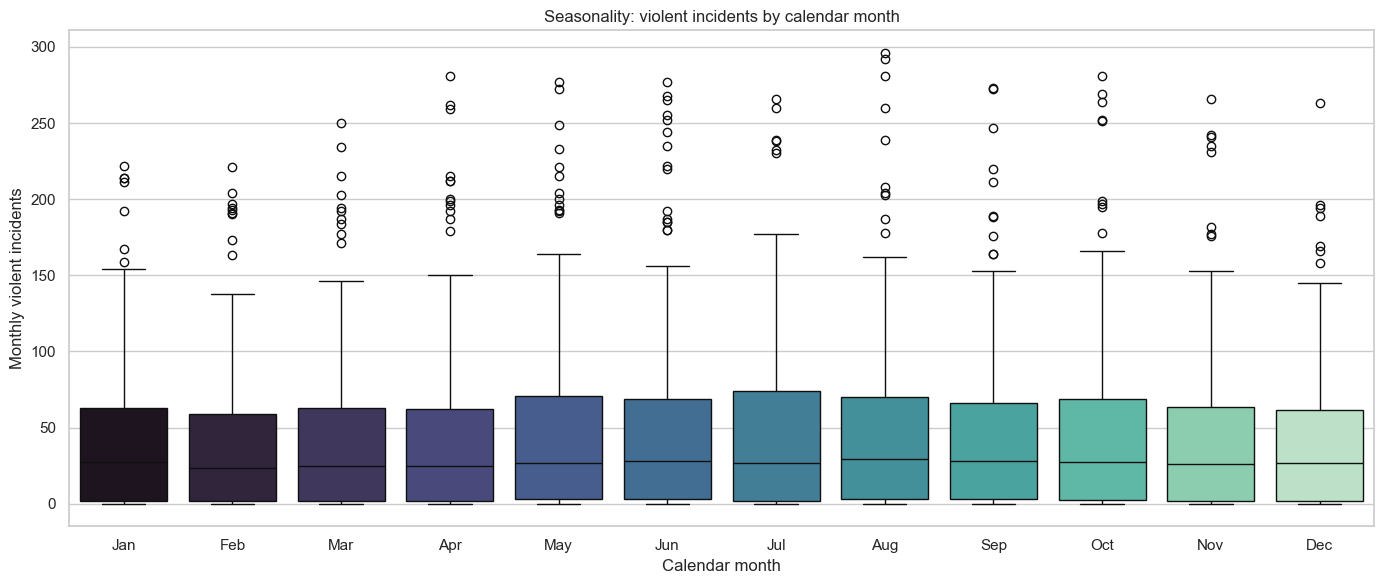

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=incidents,
    x="month",
    y="crime_violent",
    palette="mako",
)
plt.title("Seasonality: violent incidents by calendar month")
plt.xlabel("Calendar month")
plt.gca().set_xticklabels(month_names)
plt.ylabel("Monthly violent incidents")
plt.tight_layout()
plt.show()


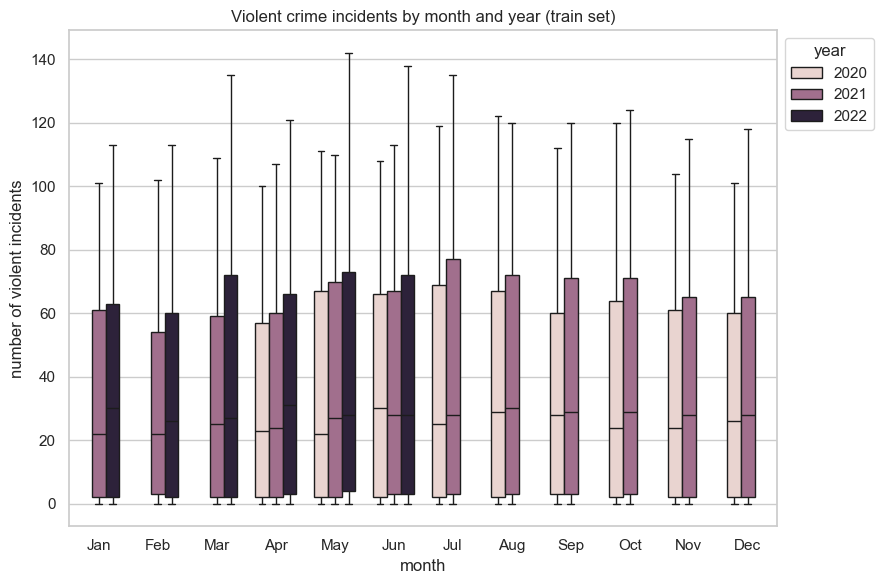

In [226]:
month_order = list(range(1, 13))
hue_order   = [2020, 2021, 2022]

plt.figure(figsize=(9, 6))
ax = sns.boxplot(
    data=incidents,
    x="month", y="crime_violent",  
    hue="year", order=month_order, hue_order=hue_order,
    width=0.7, dodge=True,
    showfliers=False,        
    whis=(5, 95),            # whiskers to 5th/95th percentiles
    linewidth=1
)

ax.set_xlabel("month")
plt.gca().set_xticklabels(month_names)
plt.ylabel("number of violent incidents")
plt.title("Violent crime incidents by month and year (train set)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

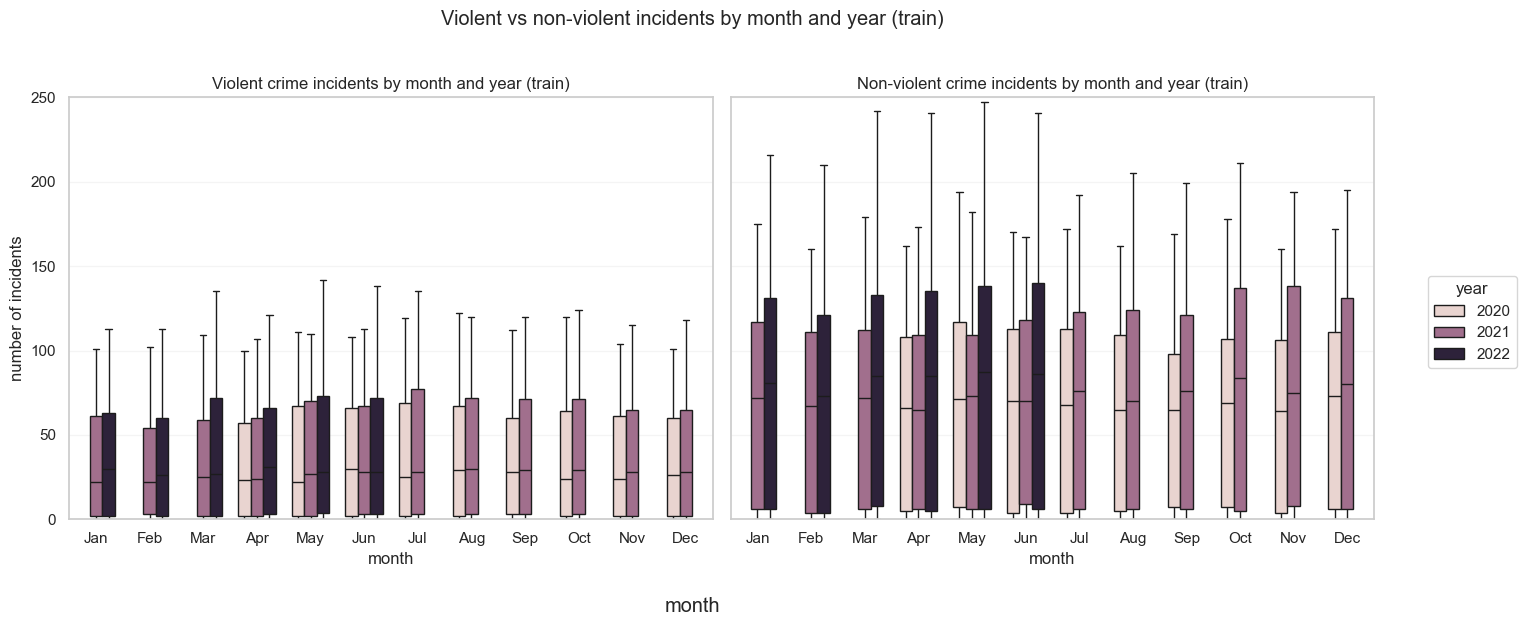

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plots = [
    ("crime_violent",      "Violent crime incidents by month and year (train)"),
    ("crime_non_violent",  "Non-violent crime incidents by month and year (train)"),
]
for ax, (ycol, title) in zip(axes, plots):
    sns.boxplot(data=incidents, x="month", y=ycol, hue="year", order=month_order, hue_order=hue_order, width=0.7, dodge=True, showfliers=False, whis=(5, 95), linewidth=1,ax=ax
    )
    ax.set_xlabel("month")
    ax.set_xticklabels(month_names)
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.2)
    ax.legend_.remove()            
axes[0].set_ylabel("number of incidents")   
axes[1].set_ylabel("")
yvals = incidents[["crime_violent", "crime_non_violent"]].to_numpy().ravel()
ymax = np.nanpercentile(yvals, 99)         
ymax = int(np.ceil(ymax / 10) * 10)         
for ax in axes:
    ax.set_ylim(0, ymax)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="year", loc="center left", bbox_to_anchor=(1.02, 0.5))
fig.suptitle("Violent vs non-violent incidents by month and year (train)", y=1.02)
fig.supxlabel("month")
fig.tight_layout()
plt.show()

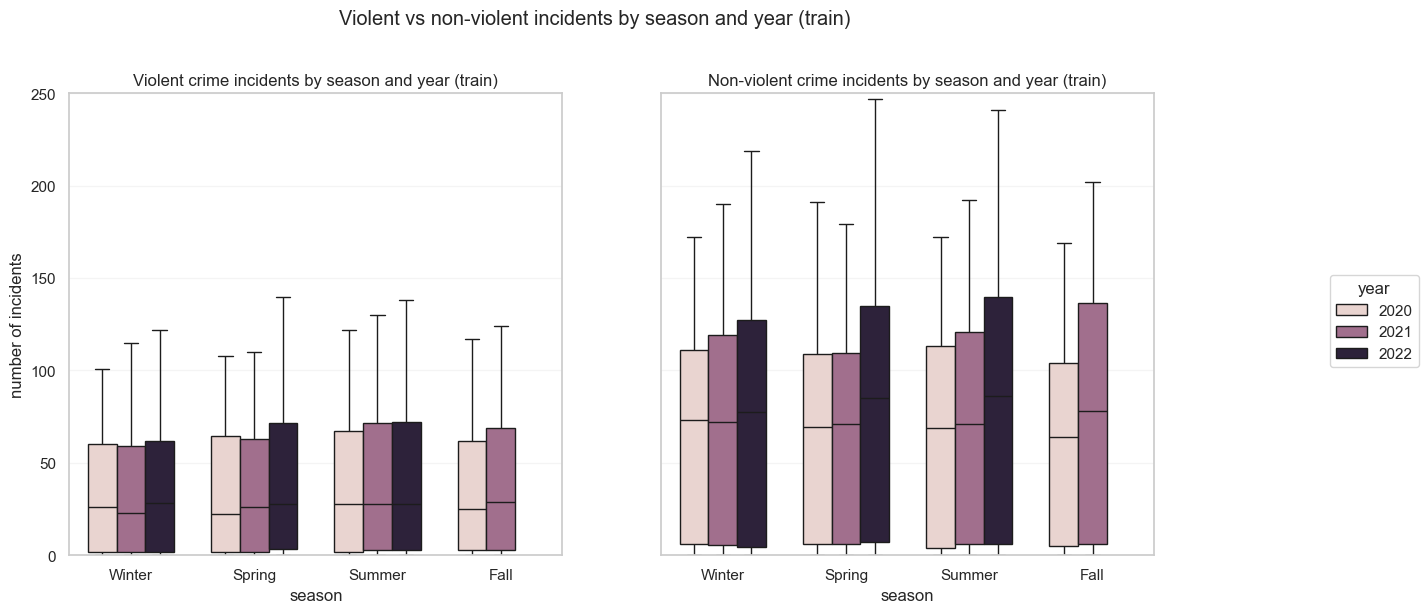

In [ ]:
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring",  4: "Spring",  5: "Spring",
    6: "Summer",  7: "Summer",  8: "Summer",
    9: "Fall",   10: "Fall",   11: "Fall"
}
incidents["season"] = incidents["month"].map(season_map)
season_order = ["Winter", "Spring", "Summer", "Fall"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plots = [
    ("crime_violent",     "Violent crime incidents by season and year (train)"),
    ("crime_non_violent", "Non-violent crime incidents by season and year (train)"),
]

for ax, (ycol, title) in zip(axes, plots):
    sns.boxplot(data=incidents, x="season", y=ycol, hue="year", order=season_order, hue_order=hue_order, width=0.7, dodge=True, showfliers=False, whis=(5, 95), linewidth=1, ax=ax
    )
    ax.set_xlabel("season")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.2)
    ax.legend_.remove()
axes[0].set_ylabel("number of incidents")
axes[1].set_ylabel("")
yvals = incidents[["crime_violent", "crime_non_violent"]].to_numpy().ravel()
ymax = np.nanpercentile(yvals, 99)
ymax = int(np.ceil(ymax / 10) * 10)
for ax in axes:
    ax.set_ylim(0, ymax)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="year", loc="center left", bbox_to_anchor=(1.02, 0.5))
fig.suptitle("Violent vs non-violent incidents by season and year (train)", y=1.02)
plt.show()

Mean incidents by season (all years combined):
        crime_violent  crime_non_violent
season                                  
Winter          38.22              75.77
Spring          41.00              77.97
Summer          44.11              75.56
Fall            41.93              73.70



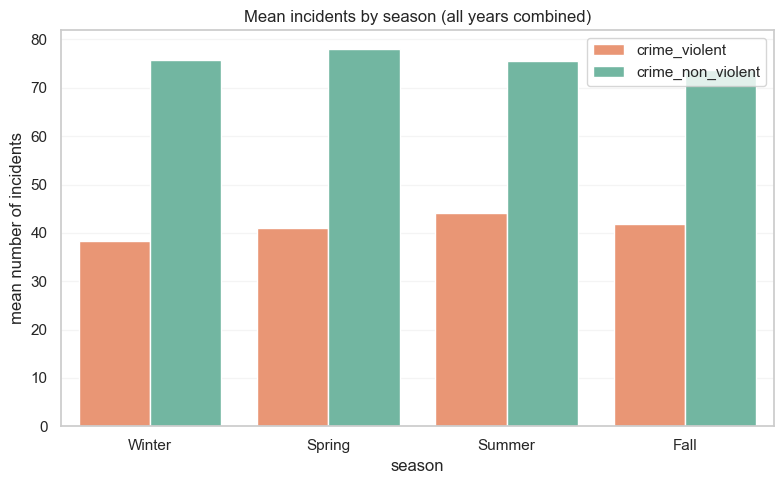

In [213]:
season_means = (incidents
    .groupby("season", observed=True)[["crime_violent", "crime_non_violent"]]
    .mean()
    .reindex(season_order)
)
print("Mean incidents by season (all years combined):")
print(season_means.round(2))
print()

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=season_means.reset_index().melt(id_vars="season", var_name="type", value_name="mean_incidents"),
    x="season", y="mean_incidents", hue="type",
    order=season_order, dodge=True, errorbar=None, ax=ax,
    palette={"crime_violent": "#fc8d62", "crime_non_violent": "#66c2a5"}
)
ax.set_xlabel("season")
ax.set_ylabel("mean number of incidents")
ax.set_title("Mean incidents by season (all years combined)")
ax.grid(True, axis="y", alpha=0.2)
ax.legend(title="")
plt.tight_layout()
plt.show()

## Correlations & relationships

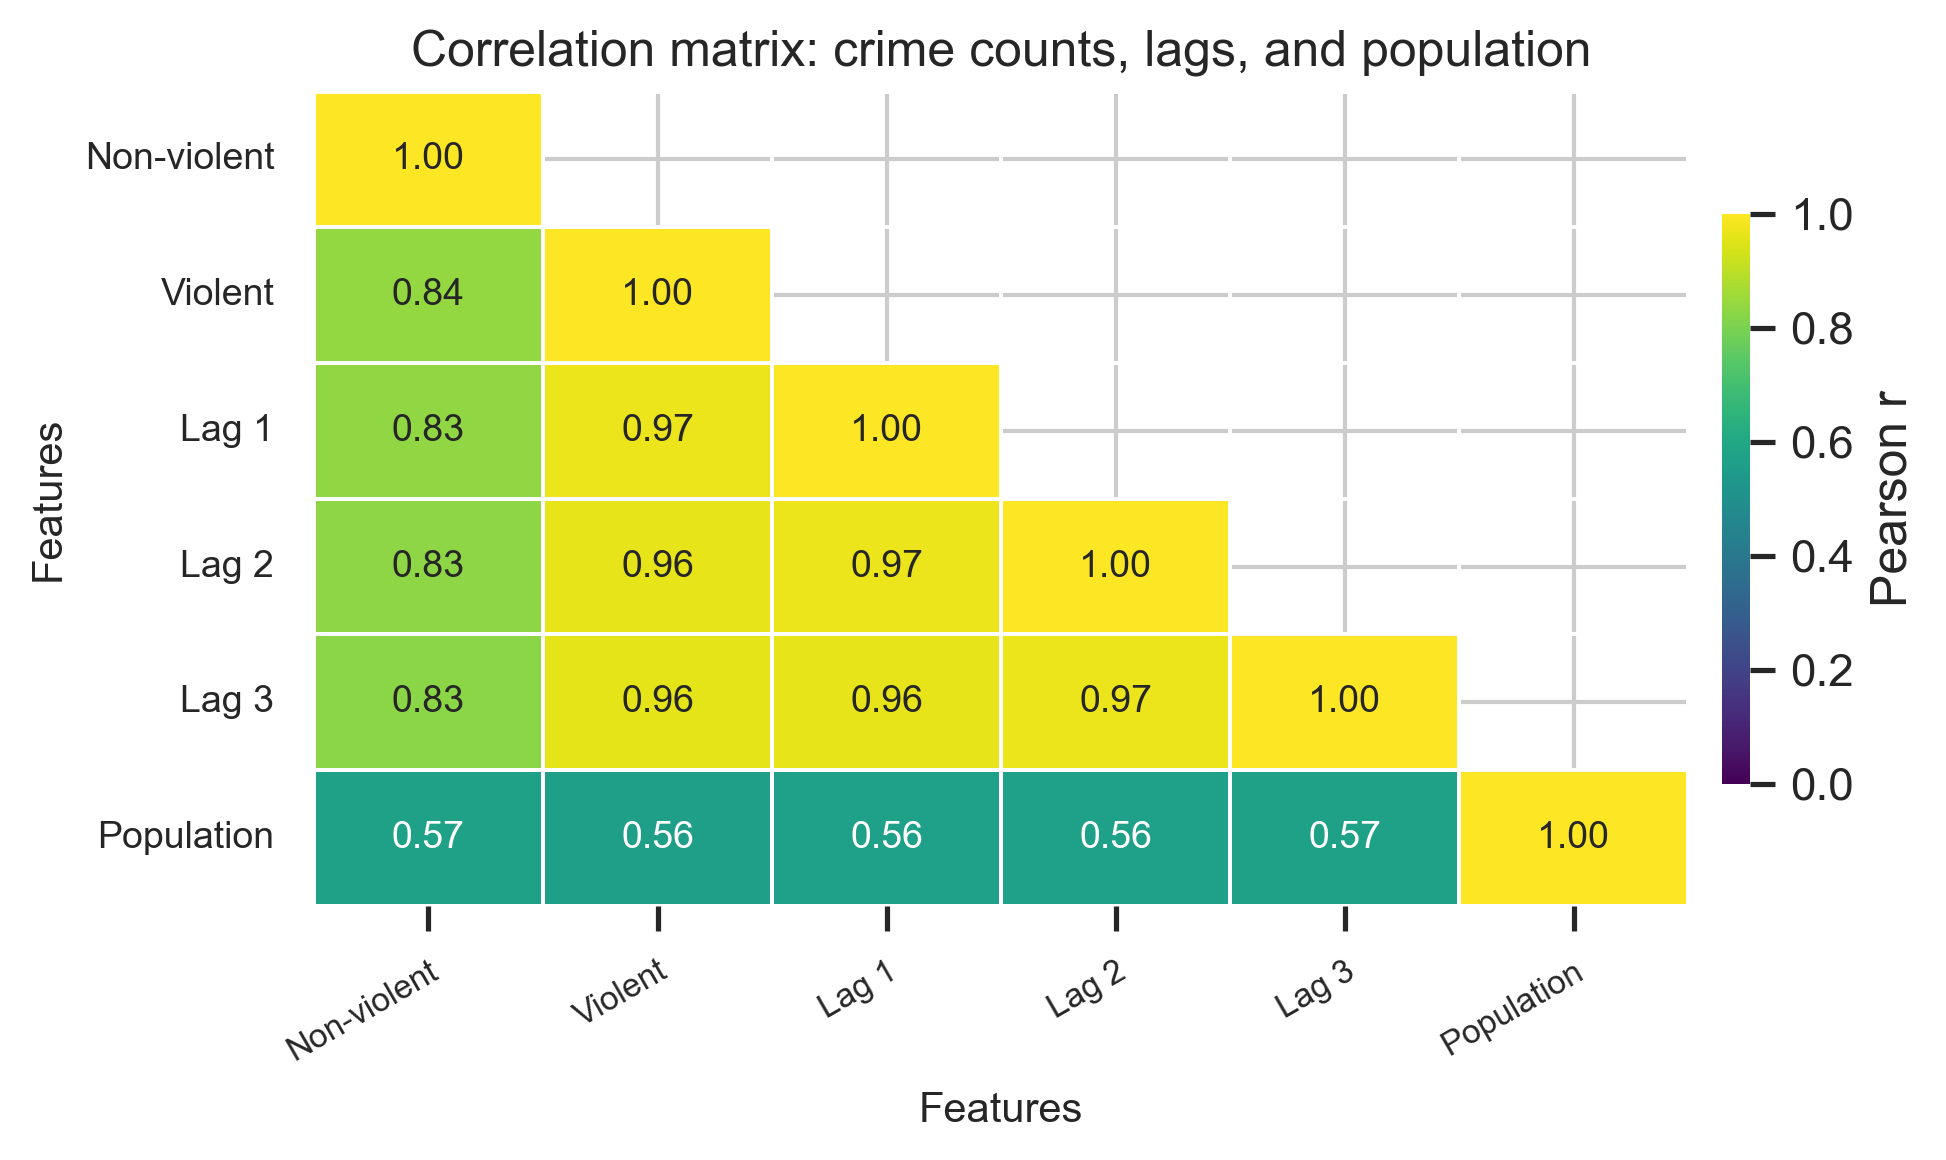

Saved heatmap to: /Users/matildaorona/github/207_ML/DS207_Final_Project/plots/correlation_heatmap.png


In [ ]:
corr_matrix = incidents[numeric_features].corr(method="pearson")

# Friendly shorter labels to save space on axes
feature_name_map = {
    "crime_non_violent": "Non-violent",
    "crime_violent": "Violent",
    "violent_lag_1": "Lag 1",
    "violent_lag_2": "Lag 2",
    "violent_lag_3": "Lag 3",
    "total_population": "Population",
}

display_corr = corr_matrix.rename(index=feature_name_map, columns=feature_name_map)
mask = np.triu(np.ones_like(display_corr, dtype=bool), k=1)
fig, ax = plt.subplots(figsize=(6.6, 3.8), dpi=300)
sns.heatmap(
    display_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9},
    cmap="viridis",
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.7, "pad": 0.02, "label": "Pearson r"},
    ax=ax,
)
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()
ax.set_title("Correlation matrix: crime counts, lags, and population", fontsize=12, pad=6)
ax.set_xlabel("Features", fontsize=10, labelpad=6)
ax.set_ylabel("Features", fontsize=10)
ax.tick_params(axis="x", labelsize=8, pad=6)
ax.tick_params(axis="y", labelsize=9)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
plt.tight_layout(pad=0.4)
export_path = Path("plots/correlation_heatmap.png")
plt.savefig(export_path, dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()
print(f"Saved heatmap to: {export_path.resolve()}")

Violent incidents are almost perfectly correlated with their three lagged values (ρ ≈ 0.96–0.97), underscoring strong temporal inertia. Current non-violent crime also has substantial overlap (ρ ≈ 0.84), while population contributes moderate signal (~0.57).

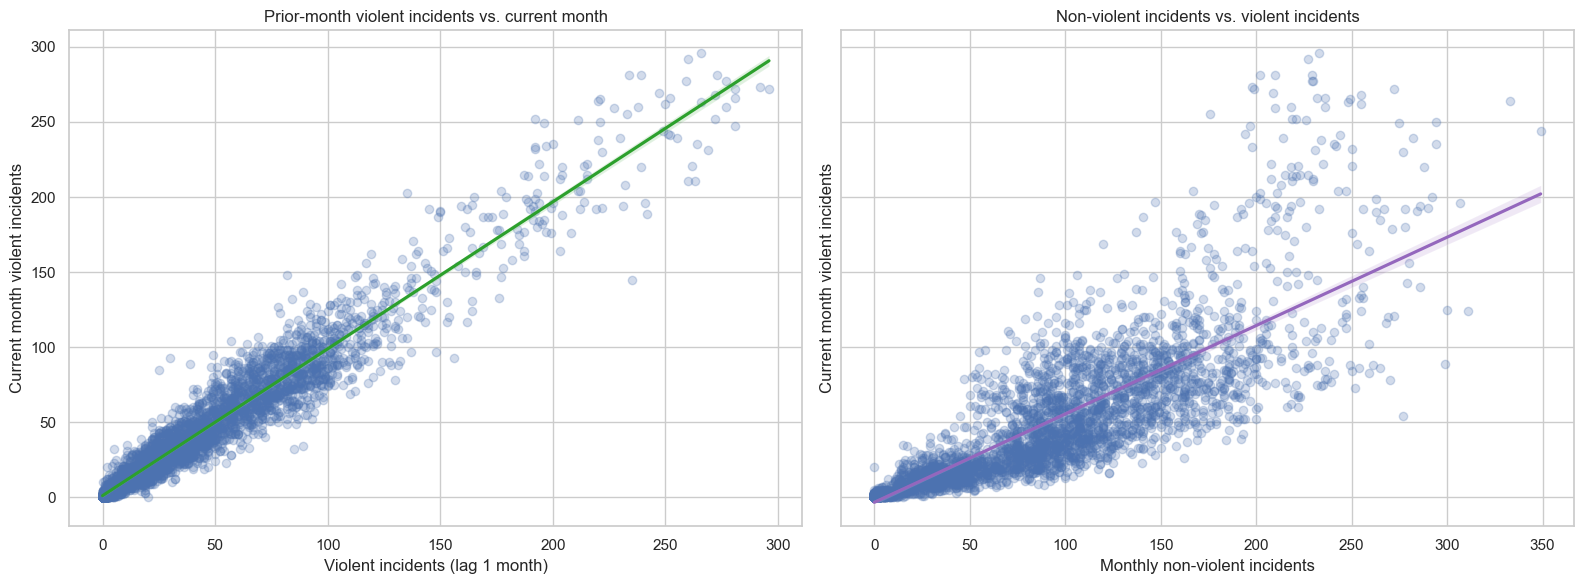

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.regplot(
    data=incidents,
    x="violent_lag_1",
    y="crime_violent",
    ax=axes[0],
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "#2ca02c"},
)
axes[0].set_title("Prior-month violent incidents vs. current month")
axes[0].set_xlabel("Violent incidents (lag 1 month)")
axes[0].set_ylabel("Current month violent incidents")
sns.regplot(
    data=incidents,
    x="crime_non_violent",
    y="crime_violent",
    ax=axes[1],
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "#9467bd"},
)
axes[1].set_title("Non-violent incidents vs. violent incidents")
axes[1].set_xlabel("Monthly non-violent incidents")
axes[1].set_ylabel("Current month violent incidents")
plt.tight_layout()
plt.show()

Regression plots confirm the relationships: recent violent history is highly predictive of current incidents, and non-violent incidents show a positive association albeit with more dispersion, hinting at shared community risk factors.

Random Forest hold-out R^2: 0.951


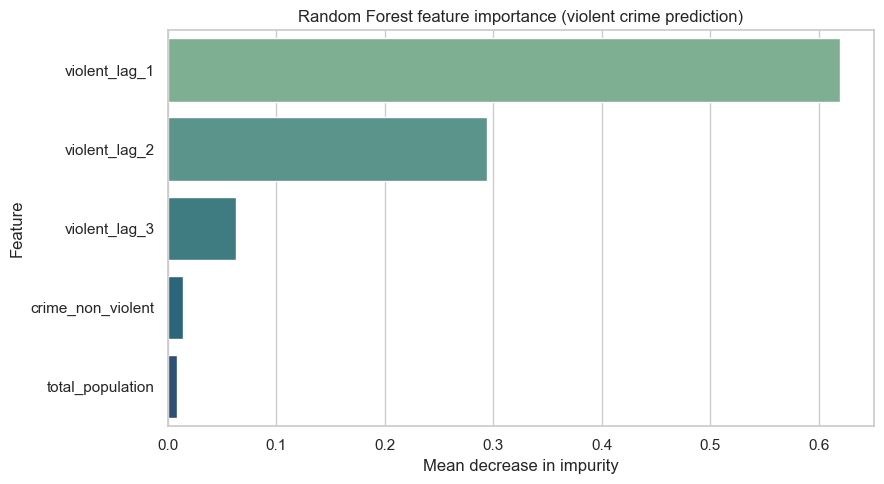

,feature_importance
violent_lag_1,0.619904
violent_lag_2,0.294410
violent_lag_3,0.063317
crime_non_violent,0.014174
total_population,0.008194


In [ ]:
feature_columns = [
    "crime_non_violent",
    "violent_lag_1",
    "violent_lag_2",
    "violent_lag_3",
    "total_population",
]

X = incidents[feature_columns]
y = incidents["crime_violent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Random Forest hold-out R^2: {r2_score(y_test, y_pred):.3f}")

importances = pd.Series(rf.feature_importances_, index=feature_columns).sort_values(ascending=False)

plt.figure(figsize=(9, 5))
sns.barplot(x=importances.values, y=importances.index, palette="crest")
plt.title("Random Forest feature importance (violent crime prediction)")
plt.xlabel("Mean decrease in impurity")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

importances.to_frame(name="feature_importance")

## Per-capita perspective

In [ ]:
incidents["population_for_rates"] = incidents["total_population"].replace({0: np.nan})
incidents["violent_per_10k"] = incidents["crime_violent"] / incidents["population_for_rates"] * 10_000
incidents["nonviolent_per_10k"] = incidents["crime_non_violent"] / incidents["population_for_rates"] * 10_000
rate_features = ["violent_per_10k", "nonviolent_per_10k"]

rate_stats = (
    incidents[["violent_per_10k", "nonviolent_per_10k"]]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T
    .rename(columns={"25%": "q1", "50%": "median", "75%": "q3"})
)
rate_stats.loc[:, ["min", "q1", "median", "q3", "max", "mean", "std"]]


,min,q1,median,q3,max,mean,std
violent_per_10k,0.0,2.544270,9.088253,16.243158,855.263158,17.341747,50.780766
nonviolent_per_10k,0.0,6.764899,22.225262,30.737828,1315.789474,31.785034,80.129983


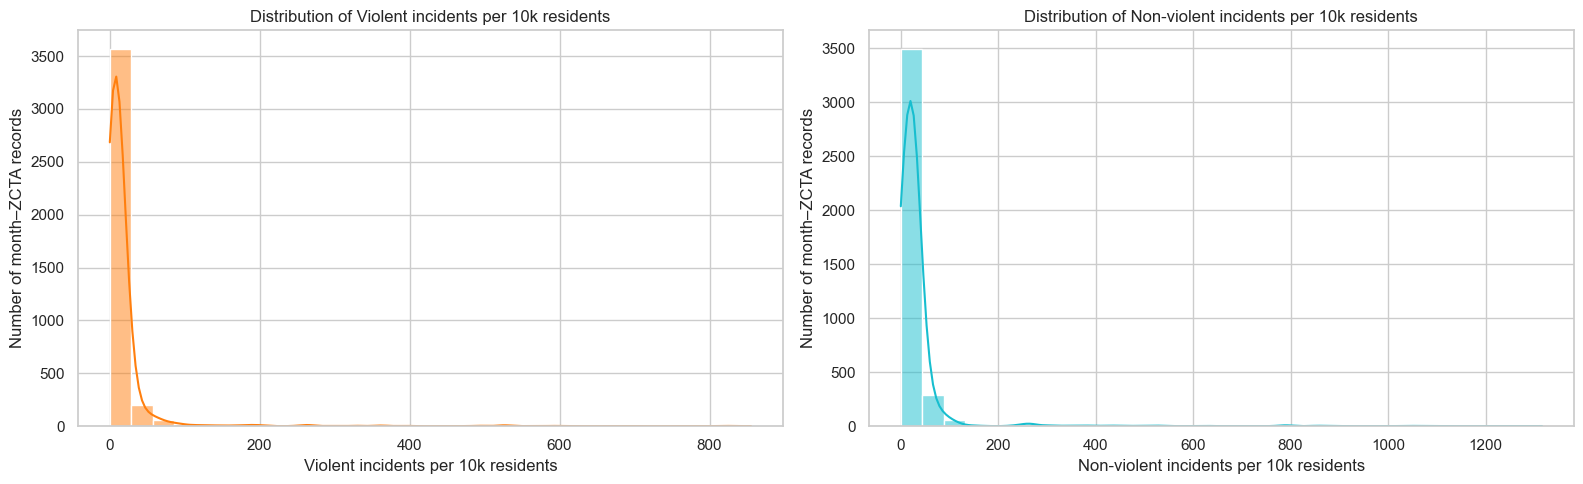

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ax, feature, title, color in [
    (axes[0], "violent_per_10k", "Violent incidents per 10k residents", "#ff7f0e"),
    (axes[1], "nonviolent_per_10k", "Non-violent incidents per 10k residents", "#17becf"),
]:
    sns.histplot(
        data=incidents,
        x=feature,
        bins=30,
        kde=True,
        ax=ax,
        color=color,
    )
    ax.set_title(f"Distribution of {title}")
    ax.set_xlabel(title)
    ax.set_ylabel("Number of month–ZCTA records")

plt.tight_layout()
plt.show()


Median per-capita violent crime is ~5 incidents per 10,000 residents, yet the top tail exceeds 40—revealing high-risk pockets that raw totals obscure. Non-violent rates have an even heavier tail, emphasising widely varying exposure levels.

In [241]:
zcta = (incidents
    .groupby("zip", as_index=False)
    .agg(
        violent=("crime_violent","sum"),
        nonviolent=("crime_non_violent","sum"),
        pop=("total_population","max")
    )
)
zcta["total"] = zcta["violent"] + zcta["nonviolent"]
# per 1k residents
zcta["violent_rate"] = 1000 * zcta["violent"] / zcta["pop"]
zcta["nonviolent_rate"] = 1000 * zcta["nonviolent"] / zcta["pop"]
zcta["violent_share"] = zcta["violent"] / zcta["total"]
zcta = zcta.replace([np.inf, -np.inf], np.nan).dropna(subset=["pop"])
zcta = zcta[zcta["pop"] > 0].copy()

print(zcta.describe()[["violent_rate","nonviolent_rate","violent_share"]].round(3))

       violent_rate  nonviolent_rate  violent_share
count       145.000          145.000        145.000
mean         46.823           85.820          0.332
std         121.927          194.570          0.158
min           0.000            0.000          0.000
25%           9.883           17.657          0.246
50%          24.835           62.505          0.312
75%          43.618           80.047          0.378
max        1282.895         1967.105          1.000


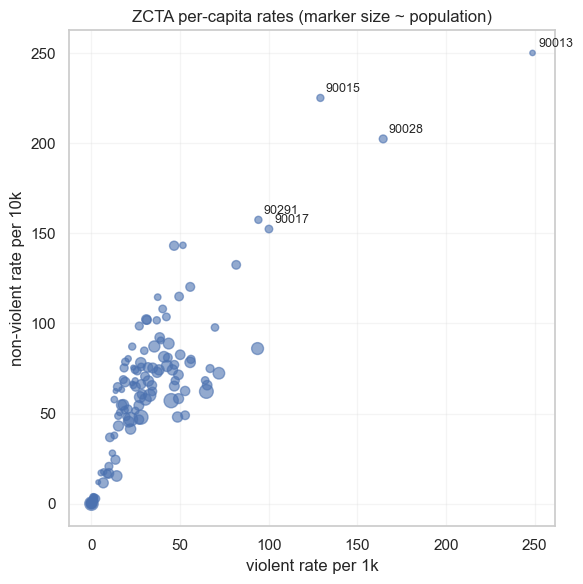

In [239]:
MIN_POP = 10000
use = zcta.query('pop >= @MIN_POP').copy()
fig, ax = plt.subplots(figsize=(6,6))
sizes = (use["pop"] / use["pop"].quantile(0.9)).clip(0.1, 2.0) * 60
ax.scatter(use["violent_rate"], use["nonviolent_rate"], s=sizes, alpha=0.6)
ax.set_xlabel("violent rate per 1k"); ax.set_ylabel("non-violent rate per 10k")
ax.set_title("ZCTA per-capita rates (marker size ~ population)")
labs = pd.concat([
    use.nlargest(5, "violent_rate"),
    use.nlargest(5, "nonviolent_rate")
]).drop_duplicates("zip")
for _, r in labs.iterrows():
    ax.annotate(r["zip"], (r["violent_rate"], r["nonviolent_rate"]), xytext=(4,4),
                textcoords="offset points", fontsize=9)
ax.grid(True, which="both", alpha=0.2)
plt.tight_layout(); plt.show()

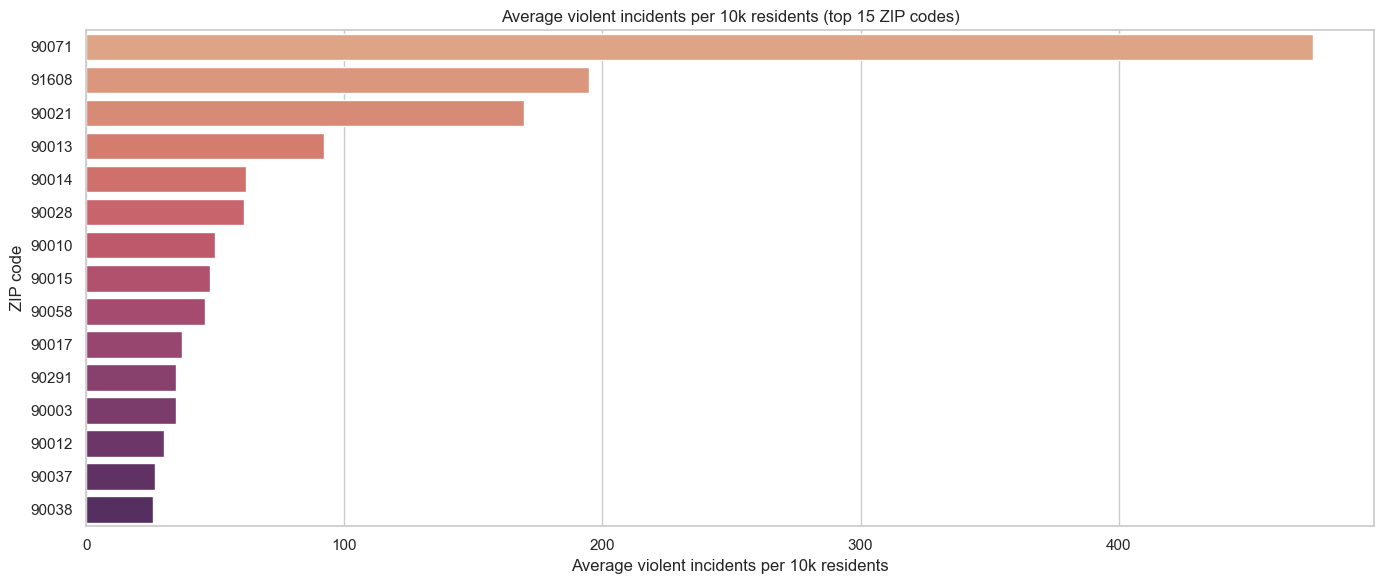

In [ ]:
percap_hotspots = (
    incidents.groupby("zip")["violent_per_10k"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
    .head(15)
)
plt.figure(figsize=(14, 6))
sns.barplot(x=percap_hotspots.values, y=percap_hotspots.index, palette="flare")
plt.title("Average violent incidents per 10k residents (top 15 ZIP codes)")
plt.xlabel("Average violent incidents per 10k residents")
plt.ylabel("ZIP code")
plt.tight_layout()
plt.show()


Industrial and mixed-use ZIP codes (e.g., 90058, 90014) climb sharply in the per-capita ranking, implying that targeted outreach or environmental design interventions could provide outsized safety gains. Residents face heightened risk independent of population size.

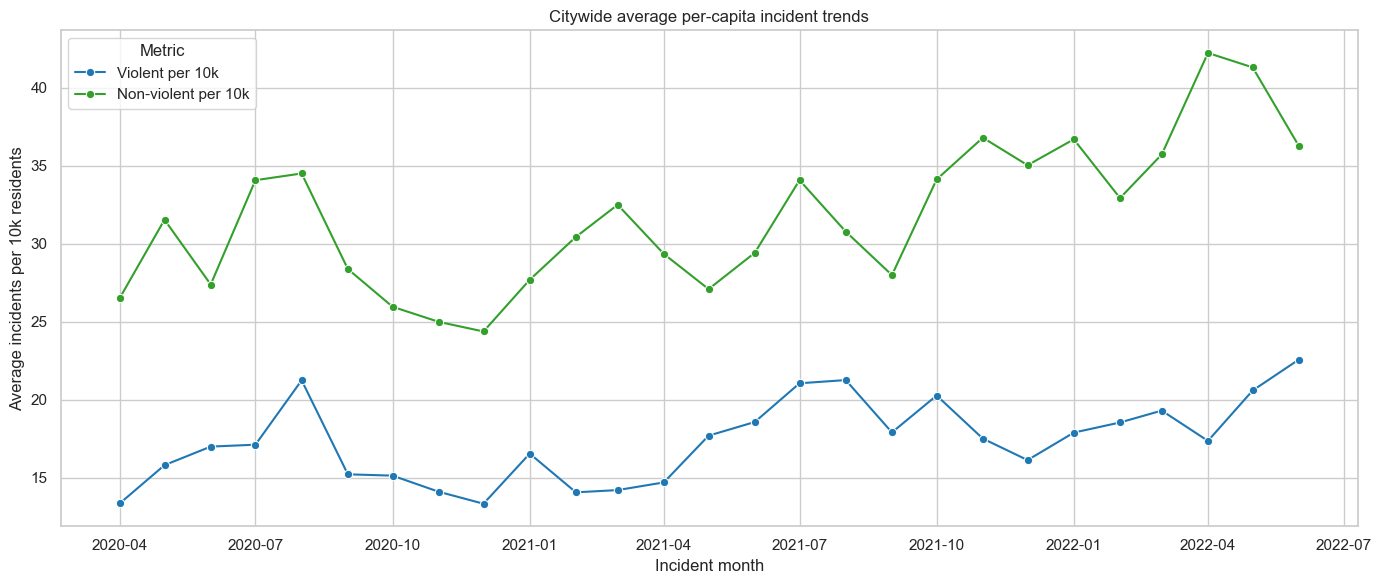

In [238]:
rate_totals = (incidents.groupby("incident_month_timestamp")[rate_features].mean().reset_index())
plt.figure(figsize=(14, 6))
for feature, label, color in [
    ("violent_per_10k", "Violent per 10k", "#1f78b4"),
    ("nonviolent_per_10k", "Non-violent per 10k", "#33a02c"),
]:
    sns.lineplot(
        data=rate_totals,
        x="incident_month_timestamp",
        y=feature,
        label=label,
        marker="o",
        color=color,
    )
plt.title("Citywide average per-capita incident trends")
plt.xlabel("Incident month")
plt.ylabel("Average incidents per 10k residents")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

## Spatial pattern: violent incidents per 100k

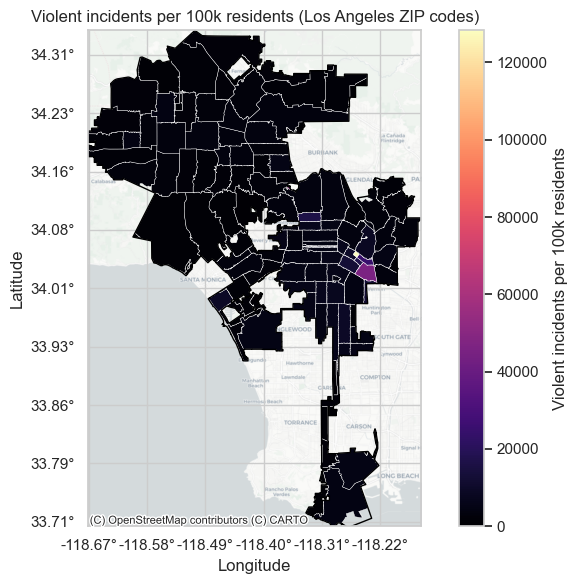

In [160]:
ZIP_PATH = Path("data/map_data/LA_County_ZIP_Codes/LA_County_ZIP_Codes.shp")
CITY_PATH = Path("data/map_data/City_Boundary/City_Boundary.shp")

zip_shapes = gpd.read_file(ZIP_PATH)
zip_field = None
for col in zip_shapes.columns:
    if col.upper() in {"ZIPCODE", "ZIP", "ZIP_CODE", "ZCTA5", "ZCTA5CE10", "ZCTA5CE20", "GEOID", "GEOID10", "GEOID20"}:
        zip_field = col
        break
if zip_field is None:
    raise ValueError("Unable to locate ZIP column in shapefile")

zip_shapes["zip"] = (
    zip_shapes[zip_field]
    .astype(str)
    .str.extract(r"(\d{5})", expand=False)
    .str.zfill(5)
)
zip_shapes = zip_shapes.to_crs(3857)

city_boundary = gpd.read_file(CITY_PATH).to_crs(3857).dissolve()

zip_metrics = (
    incidents.groupby("zip", as_index=False)
    .agg(violent=("crime_violent", "sum"), population=("total_population", "first"))
)
zip_metrics["population"] = zip_metrics["population"].replace(0, np.nan)
zip_metrics["violent_per_100k"] = zip_metrics["violent"] / zip_metrics["population"] * 100_000

choropleth = zip_shapes.merge(zip_metrics, on="zip", how="left")
choropleth_city = gpd.clip(choropleth, city_boundary)

fig, ax = plt.subplots(figsize=(8, 6))
choropleth_city.plot(
    ax=ax,
    column="violent_per_100k",
    cmap="magma",
    edgecolor="white",
    linewidth=0.3,
    legend=True,
    legend_kwds={"label": "Violent incidents per 100k residents"}
)
city_boundary.boundary.plot(ax=ax, color="black", linewidth=1.0)

ctx_extent = choropleth_city.total_bounds
ax.set_xlim(ctx_extent[0], ctx_extent[2])
ax.set_ylim(ctx_extent[1], ctx_extent[3])

try:
    cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.CartoDB.Positron)
except Exception:
    pass

transformer = Transformer.from_crs(3857, 4326, always_xy=True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{transformer.transform(x, ctx_extent[1])[0]:.2f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{transformer.transform(ctx_extent[0], y)[1]:.2f}°"))

ax.set_title("Violent incidents per 100k residents (Los Angeles ZIP codes)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


the other maps are generated in `crime_data_eda_MO.ipynb`.

The choropleth highlights elevated per-capita violent crime in several central and south LA ZIP codes, echoing the per-capita leaderboard and providing geographic context for planning deployments.

## Crime mix & emerging questions

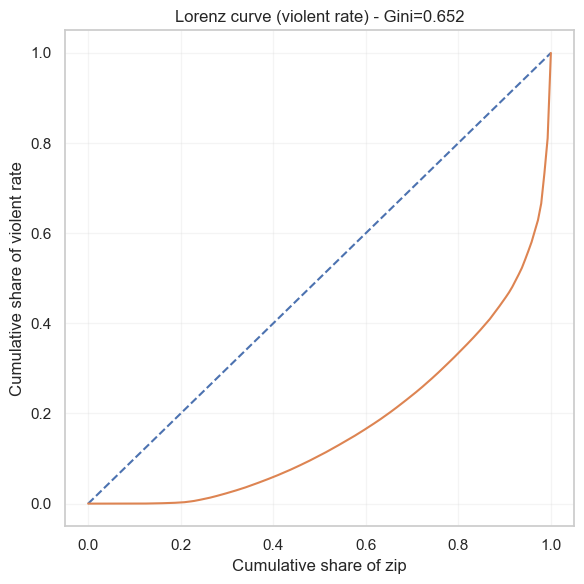

In [229]:
def lorenz_gini(x):
    x = np.sort(np.asarray(x, dtype=float))
    x = x[x >= 0]
    if x.sum() == 0:
        return None, 0.0
    cum_pop = np.linspace(0, 1, len(x), endpoint=True)
    cum_val = np.cumsum(x) / x.sum()
    gini = 1 - 2*np.trapz(cum_val, cum_pop)
    return (cum_pop, cum_val), gini

(lor_v, gini_v) = lorenz_gini(zcta["violent_rate"].fillna(0))
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(lor_v[0], lor_v[1])
plt.xlabel("Cumulative share of zip")
plt.ylabel("Cumulative share of violent rate")
plt.title(f"Lorenz curve (violent rate) - Gini={gini_v:.3f}")
plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

In [161]:
total_incidents = incidents["crime_violent"] + incidents["crime_non_violent"]
incidents["violent_share"] = np.where(total_incidents > 0, incidents["crime_violent"] / total_incidents, np.nan)

share_stats = incidents["violent_share"].describe(percentiles=[0.25, 0.5, 0.75])
share_stats


count    3525.000000
mean        0.328981
std         0.175772
min         0.000000
25%         0.240260
50%         0.315315
75%         0.404313
max         1.000000
Name: violent_share, dtype: float64

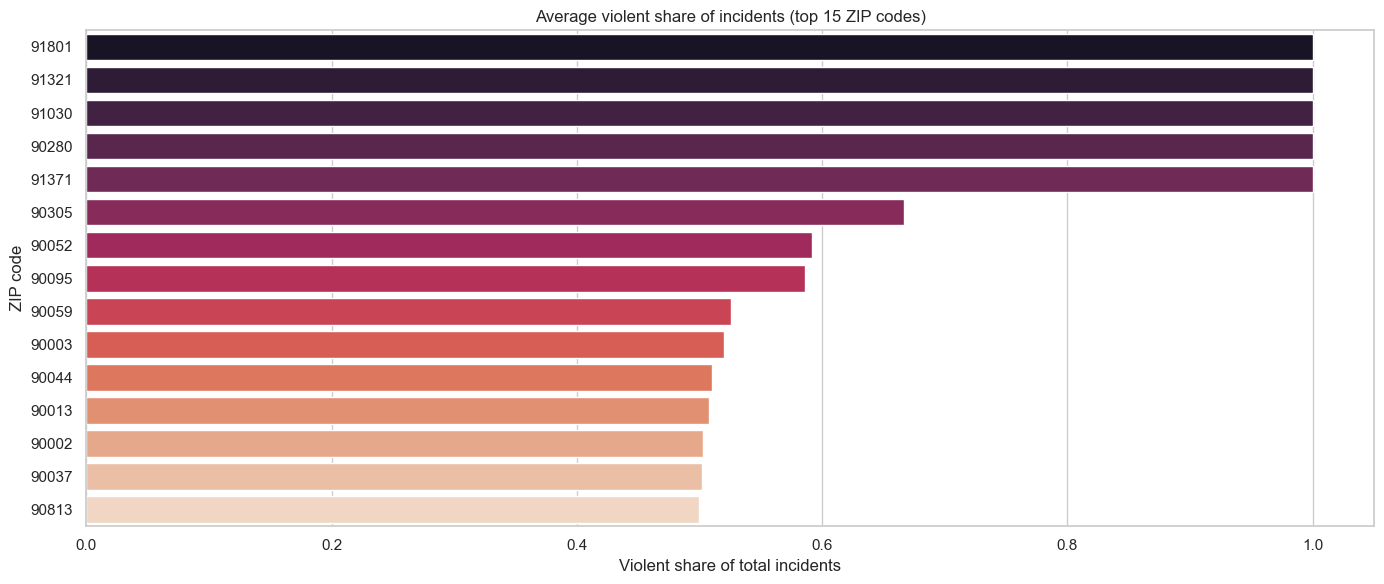

In [162]:
violent_share_top = (
    incidents.groupby("zip")["violent_share"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=violent_share_top.values,
    y=violent_share_top.index,
    palette="rocket",
)
plt.title("Average violent share of incidents (top 15 ZIP codes)")
plt.xlabel("Violent share of total incidents")
plt.ylabel("ZIP code")
plt.tight_layout()
plt.show()


Several ZIP codes report that more than half of incidents are violent, suggesting different land-use patterns or policing challenges. These areas warrant deeper exploration with socio-economic, mobility, or built-environment features.

## Key takeaways & next steps
- Violent crime displays strong temporal persistence and rises citywide alongside non-violent incidents, reinforcing the need for seasonal staffing strategies.
- Per-capita metrics reveal high-risk industrial and mixed-use ZIP codes that are less obvious in raw counts.
- Spatial patterns align with known south and central LA hotspots, supporting targeted community and law-enforcement engagement.
- High violent-share neighbourhoods could benefit from supplemental data (land use, socio-economics, service calls) to explain deviations and craft interventions.

**Next Steps**
1. Merge ACS socio-economic indicators and mobility proxies to explain outliers in per-capita risk and violent-share ratios.
2. Explore additional temporal features (e.g., rolling averages, holidays, special events) for forecasting models.